<a href="https://colab.research.google.com/github/EvaEVL/BodySegmentation/blob/main/bodysegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import tqdm

import shutil 
from tqdm import tqdm

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torchvision import transforms, models
import torch.nn as nn
import torchvision.transforms.functional as TF

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!kaggle datasets download -d tapakah68/segmentation-full-body-mads-dataset

 95% 449M/474M [00:02<00:00, 128MB/s]
100% 474M/474M [00:02<00:00, 168MB/s]


In [ ]:
!unzip /content/segmentation-full-body-mads-dataset.zip

In [6]:
data_root = '/content/segmentation_full_body_mads_dataset_1192_img'
image_path = data_root + '/images'
mask_path = data_root + '/masks'
print(os.listdir(data_root))

['collages', 'masks', 'images']


In [7]:
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision.io import read_image
import glob
from torchvision import io, transforms

import matplotlib.pyplot as plt
import random

In [8]:
IMAGE_SIZE = (224, 224)


class SegData(Dataset):
    def __init__(self, root_path, transform=None):
        super().__init__()
        
        self.transform = transform
        self.img_files = glob.glob(os.path.join(root_path,'images','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(root_path,'masks',os.path.basename(img_path)))

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, index):
        image_path = self.img_files[index]
        mask_path  = self.mask_files[index]
        image = read_image(image_path)
        mask = read_image(mask_path, mode = io.ImageReadMode(1))#read mode 1 - Gray
        
        if self.transform:
            image, mask = self.transform(image, mask)
            
        return image, mask
    
def transform(img1, img2):

    params = transforms.RandomResizedCrop.get_params(img1, scale=(0.5, 1.0), ratio=(0.75, 1.33))
    img1 = TF.resized_crop(img1, *params, size=IMAGE_SIZE)
    img2 = TF.resized_crop(img2, *params, size=IMAGE_SIZE)

    # Random horizontal flipping
    if random.random() >= 0.5:

        img1 = TF.hflip(img1)
        img2 = TF.hflip(img2)
    
    # Random rotation
    if random.random() >= 0.5:
        angle = random.randint(0, 91)
        img1 = transforms.functional.rotate(img1, angle)
        img2 = transforms.functional.rotate(img2, angle)
        
    # Randomly change the brightness, contrast, saturation and hue
    if random.random() >= 0.5:
        colorJitter = transforms.ColorJitter(brightness = (0.1, 0.8), contrast = (0.1, 0.8), saturation = (0.1, 0.8), hue = (-0.2, 0.2))
        img1 = colorJitter(img1)
    

    train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img1 = train_transforms(img1)
    
    img2 = img2.to(torch.float) / 255
    
    return img1, img2

In [9]:
data = SegData(data_root, transform)
BATCH_SIZE = 8

train_data, valid_data = torch.utils.data.random_split(dataset = data, lengths= [1000, len(data) - 1000])

train_dl = DataLoader(
        train_data,
        BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
    )


valid_dl = DataLoader(
        valid_data,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
    )

In [10]:
def print_image(img, mask):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.imshow(TF.to_pil_image(img))
    plt.subplot(122)
    plt.imshow(mask.squeeze(),'gray')
    plt.show()
    return

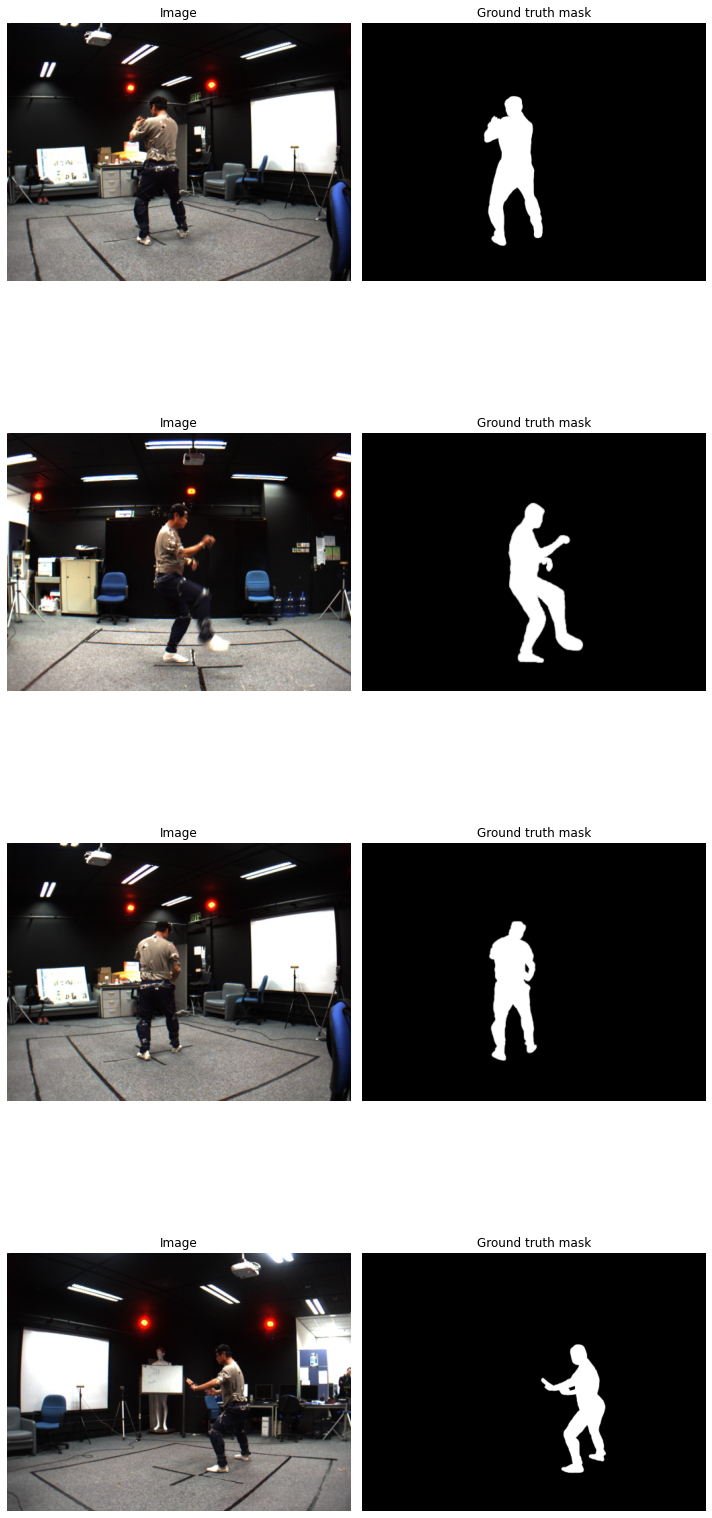

In [108]:
display_image_grid(images_filenames=list(sorted(os.listdir(image_path))), images_directory=image_path, masks_directory=mask_path, num_of_images=4)

torch.Size([8, 3, 224, 224]) torch.Size([8, 1, 224, 224])


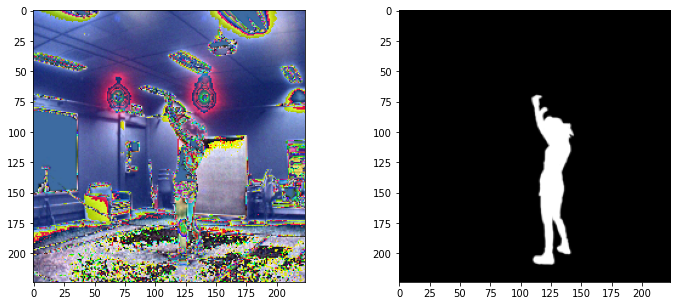

In [11]:
train_features, train_labels = next(iter(train_dl))
ra = random.randint(0, 7)
print(train_features.shape, train_labels.shape)
print_image(train_features[ra], train_labels[ra])

In [12]:
 def convrelu(in_channels, out_channels, kernel=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

In [13]:
class UnetModelResNet(nn.Module):
    #Unet model based on pretrained Restnet 18
    def __init__(self, n_class=1):
        super(UnetModelResNet, self).__init__()
        
        self.resnet_model = torchvision.models.resnet18(pretrained=True)
        self.resnet_layers = list(self.resnet_model.children())
        
        for param in self.resnet_model.parameters():
            param.requires_grad = False
        
        self.block0 = nn.Sequential(*self.resnet_layers[:3])
        self.block0_1x1 = convrelu(64, 64)
        self.block1 = nn.Sequential(*self.resnet_layers[3:5])
        self.block1_1x1 = convrelu(64, 64)
        self.block2 = nn.Sequential(*self.resnet_layers[5])
        self.block2_1x1 = convrelu(128, 128)
        self.block3 = nn.Sequential(*self.resnet_layers[6])
        self.block3_1x1 = convrelu(256, 256)
        self.block4 = nn.Sequential(*self.resnet_layers[7])
        self.block4_1x1 = convrelu(512, 512)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.relu = torch.nn.ReLU() 
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1, padding=0)
        
    def forward(self, x):
        x_original = self.conv_original_size0(x)
        x_original = self.conv_original_size1(x_original)
        
        
        block0 = self.block0(x)
        block1 = self.block1(block0)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        
        block4 = self.block4_1x1(block4)
        x = self.upsample(block4)
        block3 = self.block3_1x1(block3)
        x = torch.cat([x, block3], dim=1)
        x = self.conv_up3(x)
        
        x = self.upsample(x)
        block2 = self.block2_1x1(block2)
        x = torch.cat([x, block2], dim=1)
        x = self.conv_up2(x)
        
        x = self.upsample(x)
        block1 = self.block1_1x1(block1)
        x = torch.cat([x, block1], dim=1)
        x = self.conv_up1(x)
        
        x = self.upsample(x)
        block0 = self.block0_1x1(block0)
        x = torch.cat([x, block0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out
        
        
       

In [14]:
model = UnetModelResNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

device:  cuda


In [15]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64,

In [17]:
def ioU_metric(predicted, ground_truth, threshold = 0.5, smooth=1):
    predicted = (predicted > threshold)
    intersection = (predicted * threshold).sum(dim=(1,2,3))
    union = predicted.sum(dim=(1,2,3)) + ground_truth.sum(dim=(1,2,3)) - intersection
    iou =  ((intersection + smooth) / (union + smooth)).mean()
    return iou.item()

def dice_coefficient_metric(predicted, ground_truth, threshold = 0.5, smooth=1):
    predicted = (predicted > threshold)
    intersection = (predicted * threshold).sum(dim=(1,2,3))
    union = predicted.sum(dim=(1,2,3)) + ground_truth.sum(dim=(1,2,3)) - intersection
    f1 = ((2.0 * intersection + smooth) / (smooth + union)).mean()
    return f1.item()

In [18]:
def train_model(model, optimizer, loss, scheduler, num_epoch=1, batch_size=8):

    dataloaders = {
        'train': train_dl,
        'val': valid_dl
    }

    best_loss = 1e9
    best_model = copy.deepcopy(model.state_dict())
    
    history = {'train' : [],
               'val' : []}
    
    iou_metric = { 
            'train' : [],
            'val' : []}
    
    dice_coefficient = { 
            'train' : [],
            'val' : []}
    
    epoch_samples = 0
    m = torch.nn.Sigmoid()
    
    for epoch in range(num_epoch):
        print('Epoch {}/{} \n'.format(epoch + 1, num_epoch))
        print('-' * 10)
        time_start = time.time()
        
        
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_iou = 0.0
            running_f1 = 0.0
            
            
            for inputs, labels in tqdm(dataloaders[phase]): #dataloaders[phase]
                inputs = inputs.to(device)
                labels = labels.to(float).to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    #forward
                    outputs = model(inputs)
                    loss_value = loss(m(outputs).to(float), labels)
                    
                    #backward
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                
                running_loss += loss_value.data.cpu().numpy()
                running_iou += ioU_metric(outputs, labels)
                running_f1 += dice_coefficient_metric(outputs, labels)
                
                
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_iou = running_iou / len(dataloaders[phase])
            epoch_f1 = running_f1 / len(dataloaders[phase])
            
            
            print('{} Loss: {:.8f} '.format(phase, epoch_loss))
            history[phase].append(epoch_loss)
            iou_metric[phase].append(epoch_iou)
            dice_coefficient[phase].append(epoch_f1)
            
            
            if phase == 'val' and best_loss > loss_value.item():
                best_loss = loss_value.item()
                best_model = copy.deepcopy(model.state_dict())
                torch.save(best_model, os.getcwd() + '/weights_best')
            
        time_check = time_start - time.time()
        print('{:.0f}m {:.0f}s'.format(time_check // 60, time_check % 60), flush=True)
        
    print('best loss : {}'.format(best_loss))
    model.load_state_dict(best_model)
        
    return model, history, iou_metric, dice_coefficient
    
    
   

In [19]:
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epoch = 100

In [20]:
pretrained = True
weights_path = "/content/drive/MyDrive/weights_best_colab"
if pretrained:
  model.load_state_dict(torch.load(weights_path, map_location=device))  
else:
  model, history, iou_metric, f1metric = train_model(model = model, optimizer = optimizer, loss = loss, scheduler = scheduler, num_epoch=num_epoch);

In [43]:
 model, history, iou_metric, f1metric = train_model(model = model, optimizer = optimizer, loss = loss, scheduler = scheduler, num_epoch=20);

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1/20 

----------


100%|██████████| 125/125 [00:46<00:00,  2.70it/s]


train Loss: 0.05974148 


100%|██████████| 24/24 [00:05<00:00,  4.00it/s]

val Loss: 0.05396789 
-1m 8s


Epoch 2/20 

----------


100%|██████████| 125/125 [00:46<00:00,  2.69it/s]


train Loss: 0.04430691 


100%|██████████| 24/24 [00:06<00:00,  3.58it/s]

val Loss: 0.05674117 
-1m 7s


Epoch 3/20 

----------


100%|██████████| 125/125 [00:46<00:00,  2.69it/s]


train Loss: 0.03795865 


100%|██████████| 24/24 [00:06<00:00,  3.92it/s]

val Loss: 0.04230509 
-1m 7s


Epoch 4/20 

----------


100%|██████████| 125/125 [00:44<00:00,  2.80it/s]


train Loss: 0.03607121 


100%|██████████| 24/24 [00:06<00:00,  3.74it/s]


val Loss: 0.03547991 
-1m 9s
Epoch 5/20 

----------


100%|██████████| 125/125 [00:44<00:00,  2.83it/s]


train Loss: 0.03169998 


100%|██████████| 24/24 [00:06<00:00,  3.90it/s]


val Loss: 0.03166407 
-1m 9s
Epoch 6/20 

----------


100%|██████████| 125/125 [00:43<00:00,  2.90it/s]


train Loss: 0.03008699 


100%|██████████| 24/24 [00:05<00:00,  4.03it/s]


val Loss: 0.03082669 
-1m 11s
Epoch 7/20 

----------


100%|██████████| 125/125 [00:44<00:00,  2.83it/s]


train Loss: 0.02938840 


100%|██████████| 24/24 [00:06<00:00,  3.90it/s]

val Loss: 0.03203832 
-1m 9s


Epoch 8/20 

----------


100%|██████████| 125/125 [00:44<00:00,  2.80it/s]


train Loss: 0.02906732 


100%|██████████| 24/24 [00:05<00:00,  4.03it/s]

val Loss: 0.02818075 
-1m 9s


Epoch 9/20 

----------


100%|██████████| 125/125 [00:43<00:00,  2.87it/s]


train Loss: 0.02910050 


100%|██████████| 24/24 [00:05<00:00,  4.02it/s]

val Loss: 0.02890268 
-1m 11s


Epoch 10/20 

----------


100%|██████████| 125/125 [00:44<00:00,  2.83it/s]


train Loss: 0.02860158 


100%|██████████| 24/24 [00:06<00:00,  3.46it/s]

val Loss: 0.03025526 
-1m 9s


Epoch 11/20 

----------


100%|██████████| 125/125 [00:44<00:00,  2.83it/s]


train Loss: 0.02870201 


100%|██████████| 24/24 [00:06<00:00,  3.87it/s]

val Loss: 0.03085080 
-1m 10s


Epoch 12/20 

----------


100%|██████████| 125/125 [00:45<00:00,  2.77it/s]


train Loss: 0.02819383 


100%|██████████| 24/24 [00:06<00:00,  3.87it/s]

val Loss: 0.03008611 
-1m 9s


Epoch 13/20 

----------


100%|██████████| 125/125 [00:44<00:00,  2.83it/s]


train Loss: 0.02860232 


100%|██████████| 24/24 [00:06<00:00,  3.98it/s]

val Loss: 0.02975804 
-1m 10s


Epoch 14/20 

----------


100%|██████████| 125/125 [00:45<00:00,  2.76it/s]


train Loss: 0.02855072 


100%|██████████| 24/24 [00:06<00:00,  3.98it/s]

val Loss: 0.02890190 
-1m 9s


Epoch 15/20 

----------


100%|██████████| 125/125 [00:44<00:00,  2.83it/s]


train Loss: 0.02862487 


100%|██████████| 24/24 [00:06<00:00,  3.95it/s]

val Loss: 0.03108553 
-1m 10s


Epoch 16/20 

----------


100%|██████████| 125/125 [00:45<00:00,  2.77it/s]


train Loss: 0.02910948 


100%|██████████| 24/24 [00:06<00:00,  3.92it/s]

val Loss: 0.02949169 
-1m 9s


Epoch 17/20 

----------


100%|██████████| 125/125 [00:43<00:00,  2.84it/s]


train Loss: 0.02764944 


100%|██████████| 24/24 [00:06<00:00,  3.95it/s]

val Loss: 0.02839511 
-1m 10s


Epoch 18/20 

----------


100%|██████████| 125/125 [00:44<00:00,  2.82it/s]


train Loss: 0.02832896 


100%|██████████| 24/24 [00:06<00:00,  3.93it/s]

val Loss: 0.03029560 
-1m 9s


Epoch 19/20 

----------


100%|██████████| 125/125 [00:44<00:00,  2.82it/s]


train Loss: 0.02825498 


100%|██████████| 24/24 [00:06<00:00,  3.46it/s]

val Loss: 0.02776159 
-1m 9s


Epoch 20/20 

----------


100%|██████████| 125/125 [00:44<00:00,  2.81it/s]


train Loss: 0.02776887 


100%|██████████| 24/24 [00:06<00:00,  3.90it/s]

val Loss: 0.03120736 
-1m 9s
best loss : 0.01706319345674053


In [21]:
def plot_graphs(num_epoch, history, act):
    x = np.arange(num_epoch)
    plt.plot(x, history['train'],label = 'train', )
    plt.plot(x, history['val'], label = 'validation', )
    plt.title(f'{act} while training/validation')
    plt.xlabel('Epoch')
    plt.ylabel(act)
    plt.legend()
    plt.show()
    return

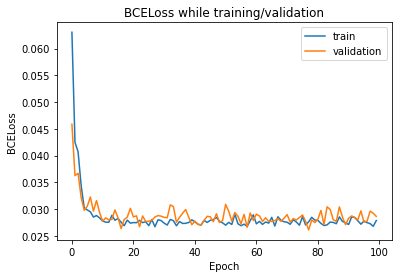

In [ ]:
plot_graphs(num_epoch, history, 'BCELoss')

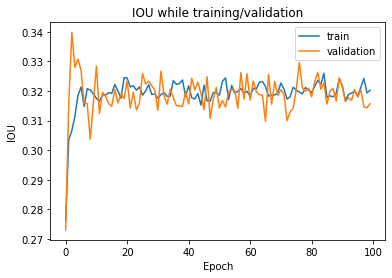

In [ ]:
plot_graphs(num_epoch,  iou_metric, 'IOU')


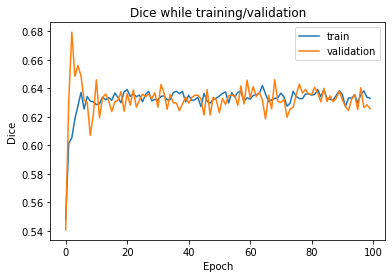

In [ ]:
plot_graphs(num_epoch,  f1metric, 'Dice')

In [95]:
def predict(model, inputs):
  inputs = torch.unsqueeze(inputs, dim=0)
  pred = model(inputs.to(device))
  return torch.squeeze(pred, 0).detach().cpu()

In [48]:
def val_transform(img1, img2):

    params = transforms.RandomResizedCrop.get_params(img1, scale=(0.5, 1.0), ratio=(0.75, 1.33))
    img1 = TF.resized_crop(img1, *params, size=IMAGE_SIZE)
    img2 = TF.resized_crop(img2, *params, size=IMAGE_SIZE)
    
    train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img1 = train_transforms(img1)
    
    img2 = img2.to(torch.float) / 255
    
    return img1, img2

In [107]:

def display_image_grid(images_filenames, images_directory, masks_directory, predict_masks=False, num_of_images=BATCH_SIZE):
  cols = 3 if predict_masks else 2
  rows = num_of_images
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
  random.shuffle(images_filenames)

  for i, image_filename in enumerate(images_filenames):
    if i >= rows:
      break

    image = read_image(os.path.join(images_directory, image_filename))
    mask = read_image(os.path.join(masks_directory, image_filename), mode = io.ImageReadMode(1)).permute(1, 2, 0)

    ax[i, 0].imshow(image.permute(1, 2, 0))
    ax[i, 1].imshow(mask.squeeze(), 'gray')

    ax[i, 0].set_title("Image")
    ax[i, 1].set_title("Ground truth mask")

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
  
    if predict_masks:
      ima, _ = val_transform(image, torch.rand((1,1,224,224)))
      predicted_mask = predict(model, ima).detach().cpu().permute(1,2,0).numpy() > 0.5
      ax[i, 2].imshow(predicted_mask.squeeze(), 'gray')
      ax[i, 2].set_title("Predicted mask")
      ax[i, 2].set_axis_off()

  plt.tight_layout()
  plt.show()

  

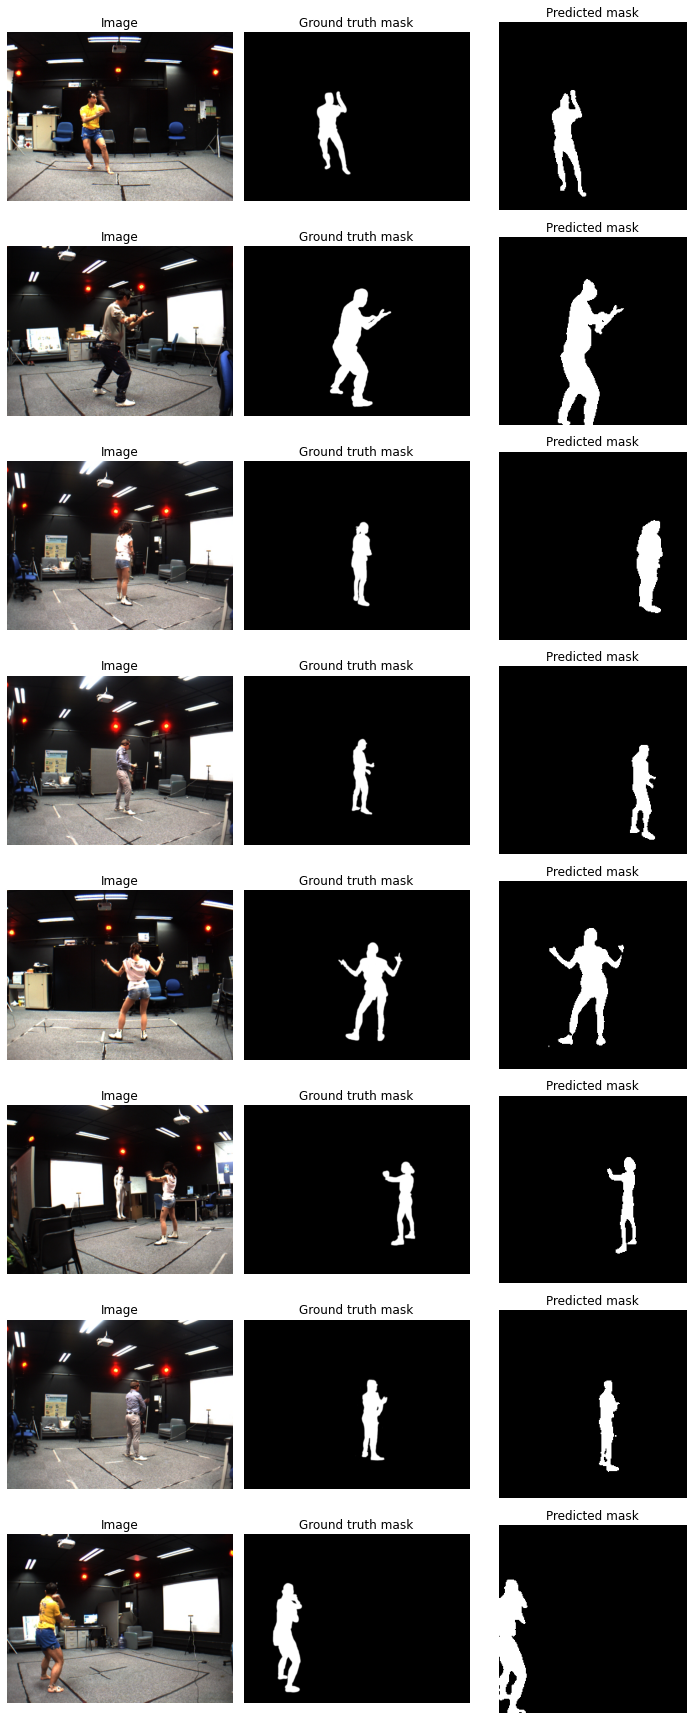

In [104]:
display_image_grid(images_filenames=list(sorted(os.listdir(image_path))), images_directory=image_path, masks_directory=mask_path, predict_masks=True)

In [44]:
import urllib.request
image_url = "https://cdn3.whatculture.com/images/2021/08/5e21602b99b1ba27-600x338.jpeg"
image_name = 'picture.jpg'

urllib.request.urlretrieve(image_url, image_name)

('picture.jpg', <http.client.HTTPMessage at 0x7f27fafde850>)

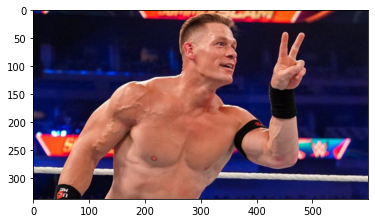

In [105]:
image = read_image('./' + image_name)
img_reshaped = image.permute(1, 2, 0)
plt.imshow(img_reshaped)

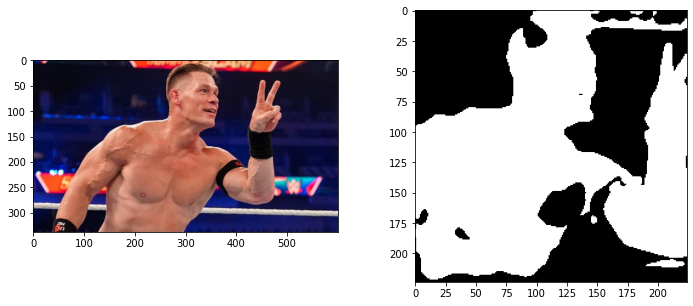

In [106]:
ima, _ = val_transform(image, torch.rand((1,1,224,224)))
pre = predict(model, ima).detach().cpu().permute(1,2,0).numpy()
print_image(img_reshaped.numpy(), pre > 0.5)